In [50]:
using Pkg
Pkg.activate("julia-ee290b")
Pkg.add("DifferentialEquations")
Pkg.add("DiffEqGPU")
Pkg.add("Plots")
Pkg.add("Graphs")
Pkg.add("Einsum")
Pkg.add("Distributed")
Pkg.add("ParallelDataTransfer")
Pkg.add("NPZ")
Pkg.add("JLD")
Pkg.add("Plots")
Pkg.add("Plotly")

 Activating environment at `~/courses/fa20/ee290b/proj/julia-ee290b/Project.toml`
   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


┌ Warning: Some registries failed to update:
│     — /home/hutch/.julia/registries/General — failed to fetch from repo
└ @ Pkg.Types /builddir/build/BUILD/julia/build/usr/share/julia/stdlib/v1.4/Pkg/src/Types.jl:1131
  Resolving package versions...
   Updating `~/courses/fa20/ee290b/proj/julia-ee290b/Project.toml`
 [no changes]
   Updating `~/courses/fa20/ee290b/proj/julia-ee290b/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/courses/fa20/ee290b/proj/julia-ee290b/Project.toml`
 [no changes]
   Updating `~/courses/fa20/ee290b/proj/julia-ee290b/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/courses/fa20/ee290b/proj/julia-ee290b/Project.toml`
 [no changes]
   Updating `~/courses/fa20/ee290b/proj/julia-ee290b/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/courses/fa20/ee290b/proj/julia-ee290b/Project.toml`
 [no changes]
   Updating `~/courses/fa20/ee290b/proj/julia-ee290b/Manifest.toml`
 [no changes]
  R

In [175]:
using Distributed
@everywhere begin
    using Einsum
    using Graphs
end    

@everywhere function evaluate_ising(J, sig)
    @einsum o := sig[i] * sig[j] * J[i,j]
    o
end

function manual_ising_solve(J)
    N = size(J,1)
    @distributed min for sig_num in 0:2^N-1
        sig = digits(sig_num, base=2, pad=N) .* 2 .+ -1
        @einsum L := sig[i] * sig[j] * J[i,j]
        (L,sig)
    end
end

function random_ising(N)
    G1 = erdos_renyi_graph(simple_graph(N, is_directed=false), N, 0.6)
    G2 = erdos_renyi_graph(simple_graph(N, is_directed=false), N, 0.6)
    J = convert(Array{Int8}, adjacency_matrix(G1) .+ (-adjacency_matrix(G2)))
    J
end

random_ising (generic function with 1 method)

In [252]:

using Einsum
using DifferentialEquations


function make_lagrange_OIM_dynamic(N)
    
    function Dt(du, u, p, t)
        J = p[1]
        Ac = p[2]
        As = p[3]
        T = p[4]
        
#         phi = u[1:N]
#         lam = u[N+1:end]
        
#         sin_delta_phi = map(sin,[phi[i] - phi[j] for i=1:N, j=1:N])
#         @einsum dphi[i] := sin_delta_phi[i,j] * J[i,j]
#         sync_term = map(sin,2 .* phi) .* lam
#         dphi *= Ac
#         dphi -= sync_term
#         dlam = As .* (map(sin, phi) .^ 2)
#         [dphi; dlam]
        for i=1:N
            du[i] = -(u[N+i] * sin(2*u[i]))
            for j=1:N
                du[i] += J[i,j] * sin(u[i] - u[j]) * Ac
            end
        end
        for i=N+1:2N
            du[i] = As * (sin(u[i-N]) ^ 2)
        end
        du
    end
    
    function DW(du, u, p, t)
        J = p[1]
        Ac = p[2]
        As = p[3]
        T = p[4]
        

        for i=1:N
            du[i] = exp(-t/T)
        end
        for i=N+1:2N
            du[i] = exp(-t/T)
        end
        du
    end
    Dt, DW
end
    
    #         sin_delta_phi = map(sin,[phi[i] - phi[j] for i=1:N, j=1:N])
#         @einsum cost_term[i] := sin_delta_phi[i,j] * J_of_t[i,j]
#         dphi = exp(-t/T) .* ones(N)
#         [dphi; zeros(N)]

function make_standard_OIM_dynamic(N)
    
    function Dt(du, u, p, t)
        J = p[1]
        Ac = p[2]
        As = p[3]
        T = p[4]
        
#         phi = u[1:N]
#         lam = u[N+1:end]
        
#         sin_delta_phi = map(sin,[phi[i] - phi[j] for i=1:N, j=1:N])
#         @einsum dphi[i] := sin_delta_phi[i,j] * J[i,j]
#         sync_term = map(sin,2 .* phi) .* lam
#         dphi *= Ac
#         dphi -= sync_term
#         dlam = As .* (map(sin, phi) .^ 2)
#         [dphi; dlam]
        for i=1:N
            du[i] = -(As * sin(2*u[i]))
            for j=1:N
                du[i] += J[i,j] * sin(u[i] - u[j]) * Ac
            end
        end
        for i=N+1:2N
            du[i] = 0
        end
        du
    end
    
    function DW(du, u, p, t)
        J = p[1]
        Ac = p[2]
        As = p[3]
        T = p[4]
        

        for i=1:N
            du[i] = exp(-t/T)
        end
        for i=N+1:2N
            du[i] = exp(-t/T)
        end
        du
    end
    Dt, DW
end

make_standard_OIM_dynamic (generic function with 1 method)

In [190]:
J = random_ising(128)
sum(map(abs, J))

7824

In [253]:
N = size(J,1)

Dt,DW = make_lagrange_OIM_dynamic(N)
phi0 = rand(N) .+ pi/2
lam0 = zeros(N)
u0 = [phi0; lam0]
# println(u0)
tspan = (0.0001, 300.0)
params = [J,1,0.1,50]
prob = ODEProblem(Dt, [phi0; lam0], tspan, params)


ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0001, 300.0)
u0: [2.4690712119093536, 1.700525343490225, 2.388458164589143, 2.401756844946246, 1.7785157388997814, 2.360111298602229, 1.9225251031082438, 1.9949145937107016, 1.873505979052189, 1.9435899794014388  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [254]:
@time sol = solve(prob)
sol.retcode

262.693007 seconds (8.35 G allocations: 124.863 GiB, 5.62% gc time)


:Success

-1464


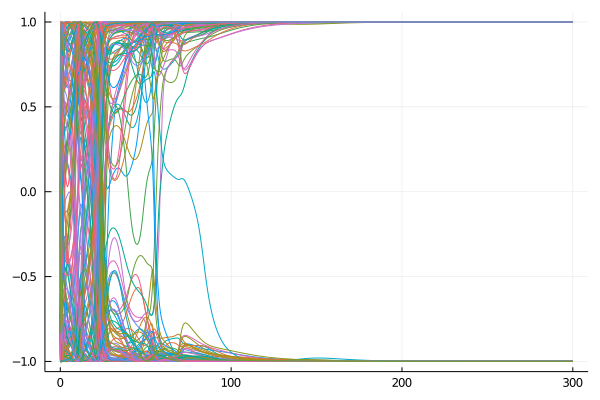

In [255]:
using Plots
t = sol.t
u = permutedims(reshape(hcat(sol.u...), (length(sol.u[1]), length(sol.u))))
# println(u[...,N])
sig_of_t = map(cos,u[:,1:N])
# println(size(sig_of_t))
sig_final = round.(Int,sig_of_t[end,:])
L_final = evaluate_ising(J, sig_final)
println(L_final)
Plots.plot(t,sig_of_t, legend=false)

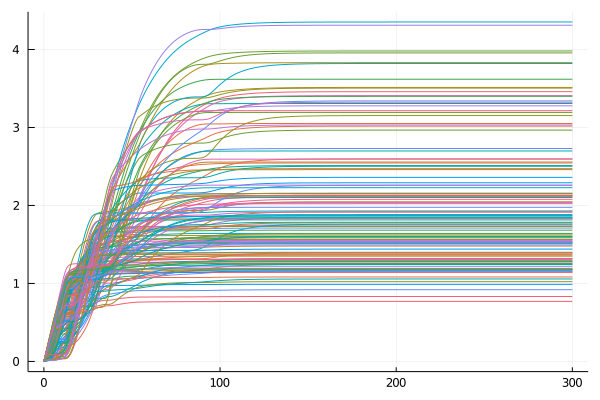

In [194]:
lam_of_t = u[:,N+1:2N]
Plots.plot(t, lam_of_t, legend=false)

In [195]:
prob_func = (prob,i,repeat) -> remake(prob,u0=[(rand(N) .+ 1) .* pi/2; zeros(N)])
output_func(sol,i) = (mapslices(u -> evaluate_ising(J, map(cos,u[1:N])), sol, dims=(1)),false)
ensemble = EnsembleProblem(prob, prob_func=prob_func, output_func=output_func, safetycopy=false)

EnsembleProblem with problem ODEProblem

In [196]:
num_trajectories = 256
@time sol = solve(
    ensemble,
    Tsit5(),EnsembleThreads(),
    trajectories=num_trajectories,
#     progress=true,
)

4402.296037 seconds (364.51 G allocations: 5.318 TiB, 66.15% gc time)


EnsembleSolution Solution of length 256 with uType:
Array{Float64,2}

In [197]:
L_finals_lag = [sol[i][end] for i in 1:num_trajectories]

256-element Array{Float64,1}:
 -1463.9966662356746
 -1467.9999891985954
 -1463.9998662768267
 -1463.9992238282393
 -1467.9999845390746
 -1455.999954454507
 -1455.9999508599622
 -1463.9999896138036
 -1463.9999869628966
 -1463.9999927300985
 -1467.995698701579
 -1431.9998982356294
 -1467.999986532709
     ⋮
 -1459.999833536236
 -1467.9987338118071
 -1463.9949916952007
 -1327.9999979297102
 -1451.9999848222612
 -1467.9999761611923
 -1467.9999076873212
 -1463.9988201334322
 -1415.9996192548126
 -1467.9889987820175
 -1467.999975490282
 -1463.9999939491288

In [268]:
N = size(J,1)

Dt,DW = make_standard_OIM_dynamic(N)
phi0 = rand(N) .+ pi/2
lam0 = zeros(N)
u0 = [phi0; lam0]
# println(u0)
tspan = (0.0001, 500.0)
params = [J,0.1,0.3,50]
prob = ODEProblem(Dt, [phi0; lam0], tspan, params)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0001, 500.0)
u0: [1.7308574790792195, 1.8804672999482395, 2.2867237354335312, 1.6991468069146407, 1.926011983550085, 1.582498550348371, 2.3684534708118252, 2.2918342985622844, 1.9074028176119207, 1.8768033125405243  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [269]:
@time sol = solve(prob)
sol.retcode

 82.137472 seconds (2.57 G allocations: 38.344 GiB, 6.21% gc time)


:Success

-1380


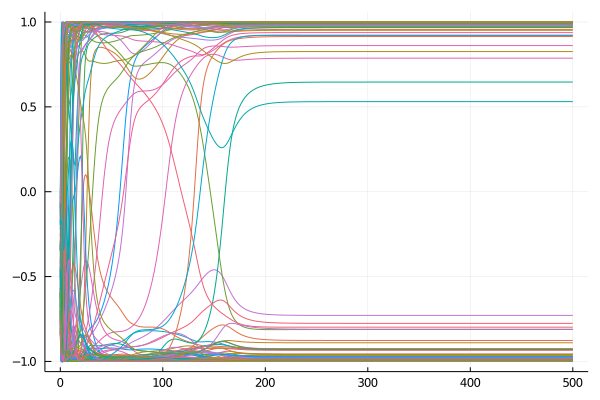

In [270]:
using Plots
t = sol.t
u = permutedims(reshape(hcat(sol.u...), (length(sol.u[1]), length(sol.u))))
# println(u[...,N])
sig_of_t = map(cos,u[:,1:N])
# println(size(sig_of_t))
sig_final = round.(Int,sig_of_t[end,:])
L_final = evaluate_ising(J, sig_final)
println(L_final)
Plots.plot(t,sig_of_t, legend=false)

In [274]:
prob_func = (prob,i,repeat) -> remake(prob,u0=[(rand(N) .+ 1) .* pi/2; zeros(N)])
output_func(sol,i) = (mapslices(u -> evaluate_ising(J, map(cos,u[1:N])), sol, dims=(1)),false)
ensemble = EnsembleProblem(prob, prob_func=prob_func, output_func=output_func, safetycopy=false)

EnsembleProblem with problem ODEProblem

In [275]:
num_trajectories = 256
@time sol = solve(
    ensemble,
    Tsit5(),EnsembleThreads(),
    trajectories=num_trajectories,
#     progress=true,
)

873.310536 seconds (66.91 G allocations: 999.833 GiB, 65.18% gc time)


EnsembleSolution Solution of length 256 with uType:
Array{Float64,2}

In [276]:
L_finals_std = [sol[i][end] for i in 1:num_trajectories]

256-element Array{Float64,1}:
 -1250.3161293494868
 -1439.8341993042065
 -1226.3117018813143
 -1327.30490171814
 -1439.8341722505588
 -1439.5999463411624
 -1220.9983965100275
 -1313.8995987168894
 -1144.3151272891257
 -1374.8022920151125
 -1372.1827622948888
 -1439.6002220653795
 -1352.5683211358762
     ⋮
 -1174.0537025527071
 -1389.3211736536236
 -1301.8751386967297
 -1338.831252353326
 -1158.1100928485448
 -1236.317837981398
 -1151.3254504869003
 -1143.2614369495395
 -1252.4093012709602
 -1389.321019203792
 -1439.6001032298213
 -1391.2283228331337

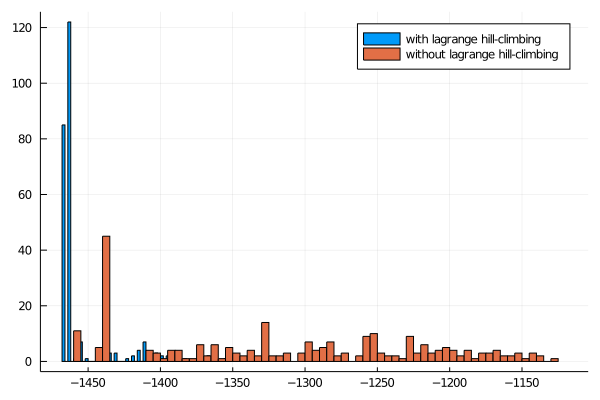

In [285]:
using Plotly

Plots.histogram(L_finals_lag, bins=100, label="with lagrange hill-climbing")
Plots.histogram!(L_finals_std, bins=100, label="without lagrange hill-climbing")

# Plots.histogram!(L_finals_std)
# Plots.title!("Lagrange hill climbing vs linear ramp")


In [284]:
sum(L_finals_lag .< -1466)

85

In [291]:
using NPZ

NPZ.npzwrite("benchmark_J_128.npz", J)